# Portugal continental recommendation

### This a project based on foursquare infomation regarding the boroughs in Portugal into groups, using clustering, to create profiles and recommend people the things that they might like to advise the best places

### 1. Import Data

In [1]:
#Import the libraries
import requests
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from bs4 import BeautifulSoup as bp
import folium # map rendering library
import json
from geopy.exc import GeocoderTimedOut
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

print('Libraries imported')

Libraries imported


In [2]:
#Take the Boroughs
url = 'https://pt.wikipedia.org/wiki/Lista_de_munic%C3%ADpios_de_Portugal_por_popula%C3%A7%C3%A3o'
r = requests.get(url)
soup = bp(r.text, 'html.parser')
table = soup.find('table', class_="wikitable sortable")
links = table.findAll('a')

Borough=[]
for i in links:
    Borough.append(i.get('title'))

df = pd.DataFrame()
print('The number of Boroughs is '+ str(len(Borough)))
df['Borough'] = Borough
Country = "PT"
df['Borough']=df['Borough'].str.replace(r"\(.*\)","")

#Link with the neighborhoods
url1 = 'https://pt.wikipedia.org/wiki/Lista_de_freguesias_de_Portugal'

The number of Boroughs is 308


In [5]:
df['District'] = None
df['Lat'] = None
df['Long'] = None

locator = Nominatim(user_agent='myGeocoder', timeout=None)
for i in range(len(df)):
    try:
        location = locator.geocode(df.loc[i,'Borough']+","+Country)
        if str(location).split(',')[2][1:] == 'Açores':
            df.loc[i,'District'] = str(location).split(',')[2][1:]
        else:
            df.loc[i,'District'] = str(location).split(',')[1][1:]
        
        df.loc[i,'Lat'] = location.latitude
        df.loc[i,'Long'] = location.longitude
        #print(i, location)
    except GeocoderTimedOut as e:
        print("Error: geocode failed on input %s with message %s"%(df.loc[i,'Borough']+","+Country, e.message))

print('places imported')

places imported


In [6]:
df = df[~df['District'].str.contains('Madeira')]
df = df[~df['District'].str.contains('Açores')]

df.sort_values('Borough',inplace=True)
df.reset_index(inplace=True,drop=True)
df

,Borough,District,Lat,Long
0,Abrantes,Santarém,39.4401,-8.12824
1,Aguiar da Beira,Guarda,40.7818,-7.53449
2,Alandroal,Évora,38.6024,-7.38443
3,Albergaria-a-Velha,Aveiro,40.6907,-8.47922
4,Albufeira,Faro,37.1445,-8.21459
...,...,...,...,...
276,Vouzela,Viseu,40.6755,-8.14843
277,Águeda,Aveiro,40.5946,-8.416
278,Évora,Alentejo Central,38.5708,-7.90928
279,Ílhavo,Aveiro,40.6001,-8.66667


In [7]:
address = 'Soure, Portugal'
geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

with open('world-countries.json') as handle:
    country_geo = json.loads(handle.read())

for i in country_geo['features']:
    if i['properties']['name'] == 'Portugal':
        country = i
        break

map_Portugal = folium.Map(location = [latitude,longitude], zoom_start=5.5)

folium.GeoJson(country, name='portugal'). add_to(map_Portugal)
folium.LayerControl().add_to(map_Portugal)

In [8]:
for lat,long,borough,district in zip(df['Lat'],df['Long'],df['Borough'],df['District']):
    label = '{}, {}'.format(borough,district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat,long], radius=5, popup=label, color='blue', fill=True, fill_color='#3186cc', fill_oppacity=0.7, parse_html=False).add_to(map_Portugal)

map_Portugal

### Explore the Boroughs

In [51]:
#Define the Foursquare credentials
CLIENT_ID = 'xxx'
CLIENT_SECRET = 'xxx'
VERSION = '20180605'
LIMIT = 100
radius=500
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: xxx
CLIENT_SECRET:xxx


In [10]:
#Get the information for the boroughs
def getNearbyVenues(names, latitudes, longitudes, radius=500):

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
        
        #create the API request to explore
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                LIMIT)
        
        #make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        #return only the relevant information for each nearby venue
        venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'],
                v['venue']['location']['lng'],
                v['venue']['categories'][0]['name']) for v in results])
        

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough',
                                 'Borough lat',
                                 'Borough lng',
                                 'venue',
                                 'venue lat',
                                 'venue lng',
                                 'venue category']
    return(nearby_venues)

In [11]:
Portugal_venues = getNearbyVenues(names=df['Borough'],
                                latitudes=df['Lat'],
                                longitudes=df['Long'])

print('venues imported')

venues imported


In [12]:
#Check the size
display(Portugal_venues.shape)
display(Portugal_venues)

#Number of venues were returned for each neighborhood
display(Portugal_venues.groupby('Borough').count())

#Check the number of unique categories
display('There are {} uniques categories.'.format(len(Portugal_venues['venue category'].unique())))

(2291, 7)

,Borough,Borough lat,Borough lng,venue,venue lat,venue lng,venue category
0,Abrantes,39.440103,-8.128236,InforEco,39.439906,-8.128367,Electronics Store
1,Albergaria-a-Velha,40.690689,-8.479221,CineTeatro Alba,40.690648,-8.478431,Theater
2,Albergaria-a-Velha,40.690689,-8.479221,Framboesa,40.687135,-8.480943,Bakery
3,Albergaria-a-Velha,40.690689,-8.479221,Jardim Ferreira Tavares,40.691667,-8.480635,Garden
4,Albergaria-a-Velha,40.690689,-8.479221,Mercado Municipal,40.689283,-8.480911,Market
...,...,...,...,...,...,...,...
2286,Óbidos,39.361951,-9.157153,O Conquistador,39.360192,-9.157607,Portuguese Restaurant
2287,Óbidos,39.361951,-9.157153,Adega do Ramada,39.360344,-9.157292,Portuguese Restaurant
2288,Óbidos,39.361951,-9.157153,A Ilustre Casa De Ramiro,39.361305,-9.156029,Mediterranean Restaurant
2289,Óbidos,39.361951,-9.157153,Estalagem do convento,39.360821,-9.156034,Hotel


,Borough lat,Borough lng,venue,venue lat,venue lng,venue category
Borough,,,,,,
Abrantes,1,1,1,1,1,1
Albergaria-a-Velha,4,4,4,4,4,4
Albufeira,1,1,1,1,1,1
Alcanena,1,1,1,1,1,1
Alcobaça,9,9,9,9,9,9
...,...,...,...,...,...,...
Vizela,8,8,8,8,8,8
Águeda,1,1,1,1,1,1
Évora,42,42,42,42,42,42


'There are 191 uniques categories.'

In [13]:
#one hot encoding
Portugal_onehot = pd.get_dummies(Portugal_venues[['venue category']], prefix="", prefix_sep="")

#add neighorhood column back to dataframe
Portugal_onehot['Borough'] = Portugal_venues['Borough']

#move neighborhood column to the first column
fixed_columns = [Portugal_onehot.columns[-1]] + list(Portugal_onehot.columns[:-1])
Portugal_onehot = Portugal_onehot[fixed_columns]
display(Portugal_onehot.head())

#examine de shape
display(Portugal_onehot.shape)

,Borough,African Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,...,Trail,Train Station,Tree,Vacation Rental,Vegetarian / Vegan Restaurant,Waterfront,Wine Bar,Wine Shop,Winery,Zoo
0,Abrantes,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Albergaria-a-Velha,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Albergaria-a-Velha,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Albergaria-a-Velha,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Albergaria-a-Velha,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(2291, 192)

In [14]:
Portugal_grouped = Portugal_onehot.groupby('Borough').mean().reset_index()
#display(Portugal_grouped)

#confirm the size
display(Portugal_grouped.shape)

(202, 192)

In [15]:
#To check the frequency 

for hood in Portugal_grouped['Borough']:
    #print('----'+hood+'---')
    temp = Portugal_grouped[Portugal_grouped['Borough'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq':2})
    #print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    #print('\n')

In [16]:
num_top_venues = 10
def return_most_common_values(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [17]:
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{]{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

#Create new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Borough'] = Portugal_grouped['Borough']

for ind in np.arange(Portugal_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_values(Portugal_grouped.iloc[ind, :], num_top_venues)

#display(neighborhoods_venues_sorted.head(10))
display(neighborhoods_venues_sorted.shape)

(202, 11)

In [18]:
kclusters = 10

Portugal_grouped_clustering = Portugal_grouped.drop('Borough', 1)

#run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Portugal_grouped_clustering)

#check cluster labels 
print(kmeans.labels_[0:])
print(len(kmeans.labels_))

[7 3 4 9 3 3 5 5 1 3 3 1 0 3 5 3 3 1 3 1 3 0 3 1 1 5 3 1 1 1 8 0 5 3 3 0 2
 5 5 3 1 2 1 3 1 0 0 3 1 1 0 1 1 0 0 6 1 1 5 0 1 3 1 0 1 1 1 1 0 3 0 1 1 3
 0 3 1 1 3 3 6 5 0 1 3 1 3 3 1 5 3 0 3 1 5 1 5 3 2 1 0 0 0 1 5 0 0 3 1 0 3
 3 5 1 1 2 1 1 3 0 3 1 6 1 3 1 5 0 9 1 1 5 0 5 6 3 3 1 1 0 0 5 5 5 3 5 1 0
 3 3 5 5 1 5 3 5 6 3 1 5 5 3 1 5 1 0 1 1 0 1 3 1 3 1 1 3 3 3 1 1 3 0 3 1 3
 5 3 5 4 1 0 3 0 1 1 0 3 1 4 0 3 0]
202


In [19]:
#add cluster labels
neighborhoods_venues_sorted.insert(0, 'cluster labels', kmeans.labels_)
#display(neighborhoods_venues_sorted)

Portugal_merged = df


In [20]:
#merge lisbon_grouped with lisbon_data to add add latitude/longitude
Portugal_merged = Portugal_merged.join(neighborhoods_venues_sorted.set_index('Borough'), on='Borough')

display(Portugal_merged)
#print(Portugal_merged.shape)

,Borough,District,Lat,Long,cluster labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abrantes,Santarém,39.4401,-8.12824,7.0,Electronics Store,Zoo,Food,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Fair,Exhibit
1,Aguiar da Beira,Guarda,40.7818,-7.53449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Alandroal,Évora,38.6024,-7.38443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albergaria-a-Velha,Aveiro,40.6907,-8.47922,3.0,Bakery,Garden,Market,Theater,Zoo,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
4,Albufeira,Faro,37.1445,-8.21459,4.0,Bakery,Zoo,Food Court,Food,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Fair
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,Vouzela,Viseu,40.6755,-8.14843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
277,Águeda,Aveiro,40.5946,-8.416,4.0,Bakery,Zoo,Food Court,Food,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Fair
278,Évora,Alentejo Central,38.5708,-7.90928,0.0,Portuguese Restaurant,Historic Site,Restaurant,Bar,Bistro,Bed & Breakfast,Hotel,Coffee Shop,Cocktail Bar,Art Museum
279,Ílhavo,Aveiro,40.6001,-8.66667,3.0,Basketball Court,Coffee Shop,Restaurant,Museum,Bakery,Concert Hall,Creperie,Empanada Restaurant,Flower Shop,Flea Market


In [21]:
#Drop the rows with NaN values
Portugal_merged.dropna(axis=0, inplace=True)
Portugal_merged.reset_index(inplace=True,drop=True)
Portugal_merged['cluster labels'] = Portugal_merged['cluster labels'].apply(int)
print('The number of boroughs are {}'.format(len(Portugal_merged)))

The number of boroughs are 203


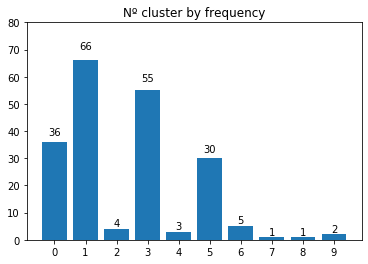

In [22]:
#Group the cluster labels to take the number of boroughs for each cluster
cluster = Portugal_merged[['cluster labels','Borough']].groupby(['cluster labels']).count()
cluster.reset_index(inplace=True)


#Create bar plot with the cluster numbers

fig,ax = plt.subplots()
bar_x = np.arange(1,11)
bar_height = list(cluster['Borough'])
bar_tick_label = list(cluster['cluster labels'])
bar_label = list(cluster['Borough'])

bar_plot = plt.bar(bar_x,bar_height,tick_label=bar_tick_label)

def autolabel(rects):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

autolabel(bar_plot)

plt.ylim(0,80)

plt.title('Nº cluster by frequency')

plt.savefig("add_text_bar_matplotlib_01.png", bbox_inches='tight')
plt.show()

In [23]:
#Take the cluster with the Borough, Lat and Long
place_cluster = Portugal_merged[["Borough","Lat", "Long", "cluster labels"]]
place_cluster

,Borough,Lat,Long,cluster labels
0,Abrantes,39.4401,-8.12824,7
1,Albergaria-a-Velha,40.6907,-8.47922,3
2,Albufeira,37.1445,-8.21459,4
3,Alcanena,39.4806,-8.68234,9
4,Alcobaça,39.5519,-8.97634,3
...,...,...,...,...
198,Vizela,41.3767,-8.30837,1
199,Águeda,40.5946,-8.416,4
200,Évora,38.5708,-7.90928,0
201,Ílhavo,40.6001,-8.66667,3


In [24]:
#create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=6.45)

#set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.hsv(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#add markers to the map
markers_colors = []
for lat, long, poi, cluster in zip(Portugal_merged['Lat'], Portugal_merged['Long'], Portugal_merged['Borough'], Portugal_merged['cluster labels']):
    label = folium.Popup(str(poi)+' Cluster '+str(cluster), parse_html=True)
    folium.CircleMarker(
            [lat, long],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)
map_clusters

#### Analyze each cluster

In [25]:
x = Portugal_merged.loc[Portugal_merged['cluster labels'] == 0, Portugal_merged.columns[[0,1] + list(range(5, Portugal_merged.shape[1]))]]
x

,Borough,District,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Amadora,Lisboa,Portuguese Restaurant,Restaurant,Playground,Gym,Café,Metro Station,Supermarket,Bakery,Pizza Place,Grocery Store
21,Arruda dos Vinhos,Lisboa,Portuguese Restaurant,Restaurant,Pharmacy,Stadium,Park,Supermarket,Diner,Fast Food Restaurant,Farmers Market,Fair
31,Borba,São Bartolomeu,Restaurant,Historic Site,Portuguese Restaurant,Beer Garden,Mediterranean Restaurant,Bar,Electronics Store,Flower Shop,Flea Market,Fish & Chips Shop
35,Campo Maior,Portalegre,Hotel,Restaurant,Memorial Site,Portuguese Restaurant,Plaza,Arts & Crafts Store,Electronics Store,Food,Flower Shop,Flea Market
45,Chamusca,Santarém,River,Portuguese Restaurant,Garden,Diner,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Fair,Exhibit
46,Chaves,Vila Real,Portuguese Restaurant,Bar,Hotel,Bakery,Creperie,Castle,Restaurant,Brewery,Hot Spring,Auto Garage
50,Coruche,Santarém,Portuguese Restaurant,Market,Gas Station,Restaurant,Sandwich Place,Zoo,Eastern European Restaurant,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
53,Cuba,Beja,Portuguese Restaurant,Restaurant,Zoo,Diner,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Fair,Exhibit
54,Elvas,Portalegre,Portuguese Restaurant,Hotel,BBQ Joint,Castle,Plaza,Arts & Crafts Store,Food Court,Food,Flower Shop,Flea Market
59,Estremoz,Évora,Portuguese Restaurant,Hotel,Train Station,Castle,Farmers Market,Bed & Breakfast,Tapas Restaurant,Bakery,Coffee Shop,Gym Pool


In [26]:
columns = list(x.head(0))
table = Portugal_merged[Portugal_merged['cluster labels'] == 0]
for i in range(2,len(columns)):
    y=table[[columns[i],'cluster labels']].groupby(columns[i]).count().sort_values('cluster labels', ascending=False)
    display(y)

,cluster labels
1th Most Common Venue,
Portuguese Restaurant,26
Hotel,5
Restaurant,2
Bakery,1
River,1
Snack Place,1


,cluster labels
2th Most Common Venue,
Restaurant,7
Coffee Shop,4
Portuguese Restaurant,4
Hotel,4
Café,3
Historic Site,2
Bar,2
Museum,1
Seafood Restaurant,1


,cluster labels
3th Most Common Venue,
Restaurant,6
Portuguese Restaurant,4
Pool,3
Train Station,2
Historic Site,2
Hotel,2
BBQ Joint,1
Pharmacy,1
Winery,1


,cluster labels
4th Most Common Venue,
Zoo,5
Diner,5
Restaurant,4
Castle,3
Portuguese Restaurant,2
Light Rail Station,1
Supermarket,1
Stadium,1
River,1


,cluster labels
5th Most Common Venue,
Flea Market,5
Eastern European Restaurant,4
Electronics Store,3
Restaurant,2
Plaza,2
Café,2
Park,2
Flower Shop,2
Art Museum,1


,cluster labels
6th Most Common Venue,
Flea Market,7
Fish & Chips Shop,5
Flower Shop,3
Electronics Store,2
Pizza Place,2
Arts & Crafts Store,2
Bed & Breakfast,2
Zoo,2
Creperie,1


,cluster labels
7th Most Common Venue,
Fish & Chips Shop,7
Fast Food Restaurant,5
Flea Market,4
Café,2
Eastern European Restaurant,2
Electronics Store,2
History Museum,1
Supermarket,1
Salad Place,1


,cluster labels
8th Most Common Venue,
Fast Food Restaurant,8
Farmers Market,6
Fish & Chips Shop,6
Bakery,3
Flea Market,3
Flower Shop,2
Food,2
Brewery,1
Coffee Shop,1


,cluster labels
9th Most Common Venue,
Farmers Market,9
Fast Food Restaurant,7
Fair,5
Fish & Chips Shop,4
Burger Joint,2
Flea Market,2
Flower Shop,2
Castle,1
Cocktail Bar,1


,cluster labels
10th Most Common Venue,
Fair,9
Farmers Market,7
Exhibit,5
Fast Food Restaurant,4
Fish & Chips Shop,2
Flea Market,2
Art Museum,1
Auto Garage,1
Gourmet Shop,1


In [29]:
abc = Portugal_merged[Portugal_merged['cluster labels'] == 0]

address = 'Leiria, Portugal'
geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_Cluster = folium.Map(location = [latitude,longitude], zoom_start=6,min_zoom = 5,max_zoom = 7)

for lat,long,borough,district in zip(abc['Lat'],abc['Long'],abc['Borough'],abc['District']):
    label = '{}, {}'.format(borough,district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat,long], radius=5, popup=label, color=rainbow[0], fill=True, fill_color=rainbow[0], fill_oppacity=0.7, parse_html=False).add_to(map_Cluster)

map_Cluster

In [30]:
x = Portugal_merged.loc[Portugal_merged['cluster labels'] == 1, Portugal_merged.columns[[0,1] + list(range(5, Portugal_merged.shape[1]))]]
x

,Borough,District,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Aljezur,Faro,Portuguese Restaurant,Café,Hostel,Bistro,Castle,Restaurant,Farmers Market,Coffee Shop,Gym Pool,Dessert Shop
11,Alvaiázere,Leiria,Café,Hostel,Stadium,Farmers Market,Eastern European Restaurant,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Fair
17,Arcos de Valdevez,Viana do Castelo,Hotel,Café,Portuguese Restaurant,Breakfast Spot,Beach,Restaurant,BBQ Joint,Bakery,Dessert Shop,Exhibit
19,Arouca,Aveiro,Café,Bar,Hotel,Tea Room,Portuguese Restaurant,Restaurant,Fried Chicken Joint,Mediterranean Restaurant,Coffee Shop,Art Museum
23,Azambuja,Lisboa,Diner,Shopping Mall,Portuguese Restaurant,Train Station,Garden,Café,Electronics Store,Flea Market,Fish & Chips Shop,Fast Food Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...
184,Vila Flor,Bragança,Café,Bakery,History Museum,River,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Fair
190,Vila Real de Santo António,Faro,Portuguese Restaurant,Café,Hotel,Bagel Shop,Snack Place,Restaurant,Boat or Ferry,Sporting Goods Shop,Mediterranean Restaurant,Gift Shop
194,Vila do Conde,Porto,Portuguese Restaurant,Pizza Place,Café,Coffee Shop,Gas Station,BBQ Joint,Bakery,Restaurant,Tea Room,Fast Food Restaurant
195,Vimioso,Bragança,Hotel,Portuguese Restaurant,Italian Restaurant,Café,Eastern European Restaurant,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market


In [31]:
columns = list(x.head(0))
table = Portugal_merged[Portugal_merged['cluster labels'] == 1]
for i in range(2,len(columns)):
    y=table[[columns[i],'cluster labels']].groupby(columns[i]).count().sort_values('cluster labels', ascending=False)
    display(y)

,cluster labels
1th Most Common Venue,
Café,33
Portuguese Restaurant,9
Hotel,5
Restaurant,4
Bar,3
Coffee Shop,3
Pizza Place,2
Bakery,1
Diner,1


,cluster labels
2th Most Common Venue,
Café,15
Portuguese Restaurant,7
Bar,6
Restaurant,5
Pizza Place,4
Tapas Restaurant,3
Hotel,3
Beach,2
Supermarket,2


,cluster labels
3th Most Common Venue,
Portuguese Restaurant,8
Bakery,5
Bar,5
Café,5
Restaurant,4
Hotel,4
Snack Place,3
History Museum,2
Gas Station,2


,cluster labels
4th Most Common Venue,
Portuguese Restaurant,9
Café,7
Restaurant,6
BBQ Joint,2
Castle,2
Park,2
Hotel,2
Eastern European Restaurant,2
Coffee Shop,2


,cluster labels
5th Most Common Venue,
Eastern European Restaurant,5
Pizza Place,4
Flower Shop,3
Bakery,3
Restaurant,3
Cosmetics Shop,3
Portuguese Restaurant,3
Electronics Store,3
Castle,3


,cluster labels
6th Most Common Venue,
Flower Shop,11
Restaurant,8
Electronics Store,5
Flea Market,5
BBQ Joint,4
Zoo,3
Cupcake Shop,2
Plaza,2
Hotel,2


,cluster labels
7th Most Common Venue,
Flea Market,13
Flower Shop,7
Fish & Chips Shop,5
Pizza Place,3
Park,3
Empanada Restaurant,3
Café,3
Portuguese Restaurant,2
Electronics Store,2


,cluster labels
8th Most Common Venue,
Fish & Chips Shop,14
Flea Market,9
Fast Food Restaurant,6
Restaurant,4
Bakery,3
Flower Shop,3
Food,3
Coffee Shop,3
Eastern European Restaurant,2


,cluster labels
9th Most Common Venue,
Fast Food Restaurant,14
Fish & Chips Shop,11
Flea Market,5
Farmers Market,5
Dessert Shop,3
Electronics Store,2
Flower Shop,2
Restaurant,2
Tea Room,2


,cluster labels
10th Most Common Venue,
Farmers Market,14
Fast Food Restaurant,13
Fair,8
Fish & Chips Shop,5
Tea Room,2
Dessert Shop,2
Exhibit,2
Market,1
Supermarket,1


In [32]:
abc = Portugal_merged[Portugal_merged['cluster labels'] == 1]

address = 'Leiria, Portugal'
geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_Cluster = folium.Map(location = [latitude,longitude], zoom_start=6, min_zoom = 5, max_zoom = 7)

for lat,long,borough,district in zip(abc['Lat'],abc['Long'],abc['Borough'],abc['District']):
    label = '{}, {}'.format(borough,district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat,long], radius=5, popup=label, color=rainbow[1], fill=True, fill_color=rainbow[1], fill_oppacity=0.7, parse_html=False).add_to(map_Cluster)

map_Cluster

In [33]:
x = Portugal_merged.loc[Portugal_merged['cluster labels'] == 2, Portugal_merged.columns[[0,1] + list(range(5, Portugal_merged.shape[1]))]]
x

,Borough,District,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
36,Carrazeda de Ansiães,Bragança,Restaurant,Coffee Shop,Big Box Store,Electronics Store,Food,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
41,Castro Daire,Viseu,Restaurant,Food,Brewery,Electronics Store,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Fair
99,Moita,Anadia,Restaurant,Zoo,Electronics Store,Food,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Fair
116,Oliveira do Hospital,Coimbra,Restaurant,Zoo,Electronics Store,Food,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Fair


In [34]:
abc = Portugal_merged[Portugal_merged['cluster labels'] == 2]

address = 'Soure, Portugal'
geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_Cluster = folium.Map(location = [latitude,longitude], zoom_start=6,min_zoom = 5,max_zoom = 7)

for lat,long,borough,district in zip(abc['Lat'],abc['Long'],abc['Borough'],abc['District']):
    label = '{}, {}'.format(borough,district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat,long], radius=5, popup=label, color=rainbow[2], fill=True, fill_color=rainbow[2], fill_oppacity=0.7, parse_html=False).add_to(map_Cluster)

map_Cluster

In [35]:
x=Portugal_merged.loc[Portugal_merged['cluster labels'] == 3, Portugal_merged.columns[[0,1] + list(range(5, Portugal_merged.shape[1]))]]
x

,Borough,District,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Albergaria-a-Velha,Aveiro,Bakery,Garden,Market,Theater,Zoo,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
4,Alcobaça,Alcobaça e Vestiaria,Plaza,Dessert Shop,Garden,Bus Station,Lounge,Café,Bakery,Food,Cosmetics Shop,Flower Shop
5,Alcochete,Setúbal,Seafood Restaurant,Restaurant,Mediterranean Restaurant,Portuguese Restaurant,Bar,Brewery,Stadium,Sushi Restaurant,Fish & Chips Shop,Fast Food Restaurant
9,Almada,Setúbal,Pizza Place,Portuguese Restaurant,Restaurant,Bar,Theater,Italian Restaurant,Bakery,Pharmacy,Creperie,Fish & Chips Shop
10,Almeida,Guarda,Stables,Historic Site,Portuguese Restaurant,Pub,Castle,Garden,Zoo,Eastern European Restaurant,Fish & Chips Shop,Fast Food Restaurant
13,Amarante,Porto,Restaurant,Bar,Bakery,Café,Hotel,Lounge,Food,Park,Pastelaria,Coffee Shop
15,Anadia,Aveiro,Pizza Place,Plaza,Concert Hall,Snack Place,Museum,Supermarket,Electronics Store,Flea Market,Fish & Chips Shop,Fast Food Restaurant
16,Ansião,Leiria,Hotel,Portuguese Restaurant,Grocery Store,Pizza Place,Plaza,Arts & Crafts Store,Electronics Store,Food,Flower Shop,Flea Market
18,Armamar,Viseu,Mediterranean Restaurant,Hotel,Bakery,Pizza Place,Food,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
20,Arraiolos,Évora,Mediterranean Restaurant,Plaza,Portuguese Restaurant,Castle,Coffee Shop,Big Box Store,Pizza Place,Gym Pool,Design Studio,Farmers Market


In [36]:
columns = list(x.head(0))
table = Portugal_merged[Portugal_merged['cluster labels'] == 3]
for i in range(2,len(columns)):
    y=table[[columns[i],'cluster labels']].groupby(columns[i]).count().sort_values('cluster labels', ascending=False)
    display(y)

,cluster labels
1th Most Common Venue,
Portuguese Restaurant,8
Plaza,5
Bar,4
Hotel,4
Bakery,4
Pizza Place,4
Seafood Restaurant,3
Restaurant,3
Tapas Restaurant,2


,cluster labels
2th Most Common Venue,
Bar,10
Zoo,9
Restaurant,5
Plaza,3
Café,3
Portuguese Restaurant,3
Hotel,2
Coffee Shop,2
Dessert Shop,1


,cluster labels
3th Most Common Venue,
Portuguese Restaurant,6
Food Court,4
Café,4
Restaurant,4
Electronics Store,4
Supermarket,3
Snack Place,2
Pizza Place,2
Bakery,2


,cluster labels
4th Most Common Venue,
Food,9
Bar,4
Portuguese Restaurant,4
Pizza Place,3
Café,3
Garden,2
Hotel,2
Bakery,2
Museum,2


,cluster labels
5th Most Common Venue,
Flower Shop,10
Bakery,5
Hotel,4
Restaurant,4
Coffee Shop,3
Food,2
Portuguese Restaurant,2
Mediterranean Restaurant,2
Lounge,2


,cluster labels
6th Most Common Venue,
Flea Market,10
Flower Shop,6
Café,3
Bar,2
Plaza,2
Lounge,2
Supermarket,1
Steakhouse,1
Snack Place,1


,cluster labels
7th Most Common Venue,
Fish & Chips Shop,11
Flea Market,5
Electronics Store,3
Bakery,3
Food,3
Burger Joint,2
Eastern European Restaurant,2
Italian Restaurant,2
Historic Site,2


,cluster labels
8th Most Common Venue,
Fast Food Restaurant,11
Fish & Chips Shop,5
Café,3
Flea Market,3
Flower Shop,2
Gastropub,2
Pizza Place,2
Food,2
Bakery,2


,cluster labels
9th Most Common Venue,
Farmers Market,11
Fish & Chips Shop,5
Fast Food Restaurant,5
Flea Market,4
Flower Shop,3
Bakery,2
Supermarket,2
Arts & Crafts Store,1
Japanese Restaurant,1


,cluster labels
10th Most Common Venue,
Fair,11
Farmers Market,7
Fish & Chips Shop,6
Fast Food Restaurant,5
Flea Market,3
Burger Joint,2
Café,2
Ice Cream Shop,2
Harbor / Marina,1


In [37]:
abc = Portugal_merged[Portugal_merged['cluster labels'] == 3]

address = 'Leiria, Portugal'
geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_Cluster = folium.Map(location = [latitude,longitude], zoom_start=6,min_zoom = 5,max_zoom = 7)

for lat,long,borough,district in zip(abc['Lat'],abc['Long'],abc['Borough'],abc['District']):
    label = '{}, {}'.format(borough,district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat,long], radius=5, popup=label, color=rainbow[3], fill=True, fill_color=rainbow[3], fill_oppacity=0.7, parse_html=False).add_to(map_Cluster)

map_Cluster

In [38]:
x=Portugal_merged.loc[Portugal_merged['cluster labels'] == 4, Portugal_merged.columns[[0,1] + list(range(5, Portugal_merged.shape[1]))]]
x

,Borough,District,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Albufeira,Faro,Bakery,Zoo,Food Court,Food,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Fair
189,Vila Nova do Corvo,Miranda do Corvo,Bakery,Zoo,Food Court,Food,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Fair
199,Águeda,Aveiro,Bakery,Zoo,Food Court,Food,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Fair


In [39]:
abc = Portugal_merged[Portugal_merged['cluster labels'] == 4]

address = 'Leiria, Portugal'
geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_Cluster = folium.Map(location = [latitude,longitude], zoom_start=6,min_zoom = 5,max_zoom = 7)

for lat,long,borough,district in zip(abc['Lat'],abc['Long'],abc['Borough'],abc['District']):
    label = '{}, {}'.format(borough,district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat,long], radius=5, popup=label, color=rainbow[4], fill=True, fill_color=rainbow[4], fill_oppacity=0.7, parse_html=False).add_to(map_Cluster)

map_Cluster

In [40]:
x=Portugal_merged.loc[Portugal_merged['cluster labels'] == 5, Portugal_merged.columns[[0,1] + list(range(5, Portugal_merged.shape[1]))]]
x

,Borough,District,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Alenquer,Lisboa,Bar,Modern European Restaurant,Portuguese Restaurant,Café,Bakery,Other Great Outdoors,Wine Bar,Cupcake Shop,Electronics Store,Flower Shop
7,Alfândega da Fé,Bragança,Bar,Pizza Place,Portuguese Restaurant,Bakery,Eastern European Restaurant,Cosmetics Shop,Creperie,Flower Shop,Flea Market,Fish & Chips Shop
14,Amares,Braga,Bagel Shop,Bar,Empanada Restaurant,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
25,Barrancos,Beja,Bar,Hotel,Portuguese Restaurant,Gastropub,Restaurant,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Fair
32,Boticas,Vila Real,Bar,Hotel,Pizza Place,Portuguese Restaurant,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Fair
37,Carregal do Sal,Viseu,Bar,Pizza Place,Pool,Train Station,Basketball Court,Zoo,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant
38,Cartaxo,Santarém,Restaurant,Food,Bar,Supermarket,Nightclub,Café,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant
58,Estarreja,Aveiro,Bar,Coffee Shop,Supermarket,Café,Nightclub,Pizza Place,Tapas Restaurant,Tea Room,Movie Theater,Park
82,Lousada,Porto,Bakery,Restaurant,Bar,Portuguese Restaurant,Coffee Shop,Snack Place,Food Court,Cupcake Shop,Deli / Bodega,Concert Hall
90,Mação,Santarém,Bar,Coffee Shop,Portuguese Restaurant,Garden,Zoo,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market


In [41]:
columns = list(x.head(0))
table = Portugal_merged[Portugal_merged['cluster labels'] == 5]
for i in range(2,len(columns)):
    y=table[[columns[i],'cluster labels']].groupby(columns[i]).count().sort_values('cluster labels', ascending=False)
    display(y)

,cluster labels
1th Most Common Venue,
Bar,17
Bakery,3
Restaurant,3
Bagel Shop,1
Cocktail Bar,1
Coffee Shop,1
Fish & Chips Shop,1
Flower Shop,1
Pizza Place,1


,cluster labels
2th Most Common Venue,
Bar,6
Hotel,4
Pizza Place,3
Portuguese Restaurant,3
Coffee Shop,2
Restaurant,2
Art Gallery,1
Flea Market,1
Food,1


,cluster labels
3th Most Common Venue,
Portuguese Restaurant,5
Bar,4
Restaurant,2
Pizza Place,2
Arts & Entertainment,1
Hotel,1
Snack Place,1
Pub,1
Pool,1


,cluster labels
4th Most Common Venue,
Café,5
Portuguese Restaurant,4
Restaurant,3
Zoo,2
Garden,2
Mediterranean Restaurant,1
Train Station,1
Supermarket,1
Recreation Center,1


,cluster labels
5th Most Common Venue,
Restaurant,4
Zoo,3
Food,3
Flower Shop,3
Nightclub,2
Bakery,1
Theater,1
Pizza Place,1
Flea Market,1


,cluster labels
6th Most Common Venue,
Flower Shop,6
Flea Market,4
Food,4
Zoo,2
Restaurant,2
Pizza Place,1
Tapas Restaurant,1
Snack Place,1
Sandwich Place,1


,cluster labels
7th Most Common Venue,
Flea Market,7
Flower Shop,6
Fish & Chips Shop,4
Electronics Store,2
Bar,1
Castle,1
Creperie,1
Empanada Restaurant,1
Fast Food Restaurant,1


,cluster labels
8th Most Common Venue,
Flea Market,7
Fish & Chips Shop,6
Fast Food Restaurant,5
Cupcake Shop,2
Flower Shop,2
Electronics Store,1
Farmers Market,1
Food,1
Italian Restaurant,1


,cluster labels
9th Most Common Venue,
Fast Food Restaurant,7
Fish & Chips Shop,7
Farmers Market,5
Electronics Store,2
Flea Market,2
Café,1
Deli / Bodega,1
Fair,1
Flower Shop,1


,cluster labels
10th Most Common Venue,
Farmers Market,7
Fast Food Restaurant,7
Fair,5
Fish & Chips Shop,3
Brewery,1
Concert Hall,1
Exhibit,1
Flea Market,1
Flower Shop,1


In [42]:
abc = Portugal_merged[Portugal_merged['cluster labels'] == 5]

address = 'Leiria, Portugal'
geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_Cluster = folium.Map(location = [latitude,longitude], zoom_start=6,min_zoom = 5,max_zoom = 7)

for lat,long,borough,district in zip(abc['Lat'],abc['Long'],abc['Borough'],abc['District']):
    label = '{}, {}'.format(borough,district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat,long], radius=5, popup=label, color=rainbow[5], fill=True, fill_color=rainbow[5], fill_oppacity=0.7, parse_html=False).add_to(map_Cluster)

map_Cluster

In [43]:
x=Portugal_merged.loc[Portugal_merged['cluster labels'] == 6, Portugal_merged.columns[[0,1] + list(range(5, Portugal_merged.shape[1]))]]
x

,Borough,District,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
55,Entroncamento,Santarém,Café,Coffee Shop,Zoo,Electronics Store,Food,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
81,Lourinhã,Lisboa,Café,Zoo,Electronics Store,Food,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Fair
123,Paços de Ferreira,Porto,Café,Zoo,Electronics Store,Food,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Fair
135,Portalegre,Alto Alentejo,Café,Zoo,Electronics Store,Food,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Fair
157,Sever do Vouga,Aveiro,Café,Portuguese Restaurant,Movie Theater,Convenience Store,Electronics Store,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market


In [44]:
abc = Portugal_merged[Portugal_merged['cluster labels'] == 6]

address = 'Leiria, Portugal'
geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_Cluster = folium.Map(location = [latitude,longitude], zoom_start=6,min_zoom = 5,max_zoom = 7)

for lat,long,borough,district in zip(abc['Lat'],abc['Long'],abc['Borough'],abc['District']):
    label = '{}, {}'.format(borough,district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat,long], radius=5, popup=label, color=rainbow[6], fill=True, fill_color=rainbow[6], fill_oppacity=0.7, parse_html=False).add_to(map_Cluster)

map_Cluster

In [45]:
x=Portugal_merged.loc[Portugal_merged['cluster labels'] == 7, Portugal_merged.columns[[0,1] + list(range(5, Portugal_merged.shape[1]))]]
x

,Borough,District,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abrantes,Santarém,Electronics Store,Zoo,Food,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Fair,Exhibit


In [46]:
abc = Portugal_merged[Portugal_merged['cluster labels'] == 7]

address = 'Leiria, Portugal'
geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_Cluster = folium.Map(location = [latitude,longitude], zoom_start=6,min_zoom = 5,max_zoom = 7)

for lat,long,borough,district in zip(abc['Lat'],abc['Long'],abc['Borough'],abc['District']):
    label = '{}, {}'.format(borough,district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat,long], radius=5, popup=label, color=rainbow[7], fill=True, fill_color=rainbow[7], fill_oppacity=0.7, parse_html=False).add_to(map_Cluster)

map_Cluster

In [47]:
Portugal_merged.loc[Portugal_merged['cluster labels'] == 8, Portugal_merged.columns[[0,1] + list(range(5, Portugal_merged.shape[1]))]]

,Borough,District,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,Bombarral,Leiria,Auto Garage,Zoo,Electronics Store,Food,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Fair


In [48]:
abc = Portugal_merged[Portugal_merged['cluster labels'] == 8]

address = 'Leiria, Portugal'
geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_Cluster = folium.Map(location = [latitude,longitude], zoom_start=6,min_zoom = 5,max_zoom = 7)

for lat,long,borough,district in zip(abc['Lat'],abc['Long'],abc['Borough'],abc['District']):
    label = '{}, {}'.format(borough,district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat,long], radius=5, popup=label, color=rainbow[8], fill=True, fill_color=rainbow[8], fill_oppacity=0.7, parse_html=False).add_to(map_Cluster)

map_Cluster

In [49]:
x=Portugal_merged.loc[Portugal_merged['cluster labels'] == 9, Portugal_merged.columns[[0,1] + list(range(5, Portugal_merged.shape[1]))]]
x

,Borough,District,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Alcanena,Santarém,River,Zoo,Electronics Store,Food,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Fair
129,Peniche,Leiria,River,Zoo,Electronics Store,Food,Flower Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Fair


In [50]:
abc = Portugal_merged[Portugal_merged['cluster labels'] == 9]

address = 'Leiria, Portugal'
geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_Cluster = folium.Map(location = [latitude,longitude], zoom_start=6,min_zoom = 5,max_zoom = 7)

for lat,long,borough,district in zip(abc['Lat'],abc['Long'],abc['Borough'],abc['District']):
    label = '{}, {}'.format(borough,district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat,long], radius=5, popup=label, color=rainbow[9], fill=True, fill_color=rainbow[9], fill_oppacity=0.7, parse_html=False).add_to(map_Cluster)

map_Cluster